# Analiza Podatkov: Daily Discussion -Komentarji

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np

import glob

import os

import re

## Nalaganje podatkov

### Cena Bitcoinov

In [2]:
# Funkcije za parsanje podatkov

def parse_prices_file(file):
    prices = []
    
    first_line = True
    for line in file:
        if (first_line):
            first_line = False
            continue
        
        line_split = line.split(";")

        price = float(line_split[2])
        
        prices.append(price)
    
    return prices

In [3]:
# Naloži podatke

bitstamp_prices_file = open("../data/price/bitstamp_bitcoin.txt")

bitstamp_prices = parse_prices_file(bitstamp_prices_file)

In [4]:
# Izračuna gibanje cene

bitstamp_price_correctPredictions = []

for i in range(len(bitstamp_prices) -1):
    price = bitstamp_prices[i]
    nextPrice = bitstamp_prices[i +1]
    
    if nextPrice > price:
        correct_prediction = 1
    if nextPrice == price:
        correct_prediction = 0
    if nextPrice < price:
        correct_prediction = -1
        
    bitstamp_price_correctPredictions.append(correct_prediction)
        
    
print("Correct price predictions (for Bitstamp):")
print(bitstamp_price_correctPredictions)

Correct price predictions (for Bitstamp):
[1, -1, -1, -1, 1, -1, -1, 1, 1]


### Reddit

In [5]:
# Funkcije za parsanje podatkov

def parse_submission_file(file):
    comments = []
    for line_num, line in enumerate(file):
        if line_num == 0:
            file_creationTime = int(line[17:])
            continue
        if line_num == 1:
            subreddit = line[11:]
            continue
        if line_num == 2:
            submission_title = line[18:]
            continue
        if line_num == 3:
            submission_creationTime = int(line[24:])
            continue
        if line_num == 4:
            submission_score = int(line[18:])
            continue
        if line_num == 5:
            continue
        if line_num == 6:
            continue
        comments.append(pase_comment_line(line))
    return (file_creationTime, 
            subreddit, 
            submission_title, 
            submission_creationTime,
            submission_score,
            comments)

def pase_comment_line(line):
    line_split = line.split("\t")
    level = int(line_split[0])
    creationTime = int(line_split[1])
    score = int(line_split[2])
    content = line_split[3]
    
    return (level,
            creationTime,
            score,
            content)

In [6]:
# Naloži vse potrebne podatke

def get_dd_dates(file_names):
    r = []
    for file_name in file_names:
        split = file_name.split("/")
        date = split[-1].replace(".txt", "")
        r.append(date)
    return r

def load_daily_discussion(file_names):
    r = []
    for file_name in file_names:
        file = open(file_name)
        r.append(parse_submission_file(file))
    return r



# naloži DailyDiscussion-Bitcoin
bitcoinDD_filenames = sorted(glob.glob("../data/reddit/daily_discussion_bitcoin/*.txt"))

bitcoinDD_submissions = load_daily_discussion(bitcoinDD_filenames)

# naloži DailyDiscussion-Cryptocurrency
cryptocurrencyDD_filenames = sorted(glob.glob("../data/reddit/daily_discussion_cryptocurrency/*.txt"))

cryptocurrencyDD_submissions = load_daily_discussion(cryptocurrencyDD_filenames)

# prodobi datume za katere obstajajo podatki
dd_dates = get_dd_dates(bitcoinDD_filenames)

## Izračun

In [7]:
positive_words = [
    "increase",
    "high",
    "top",
    "buy",
    "invest",
    "positive",
    "up",
    "good",
    "happy",
    "\+",
    "gain"
    "win",
    "max",
    "flourish",
    "rise",
]

negative_words = [
    "decrease",
    "low",
    "bottom",
    "sell",
    #"sell-out", # this word is cowered with sell
    "negative",
    "down",
    "bad",
    "sad",
    "\-",
    "loss",
    "lose",
    "min",
    "decline",
    "fall",
]

compiled_positive_words = [re.compile((word + ".*")) for word in positive_words]
compiled_negative_words = [re.compile((word + ".*")) for word in negative_words]

In [8]:
# _predictions = price:
#    * Increase -> 1
#    * Same -> 0
#    * Decrease -> -1

# pomožne funkcije

def get_num_of_positive_words(text):
    r = 0
    for word in text.split(" "):
        for positive_word in compiled_positive_words:
            isMatch = bool(re.match(positive_word, word))
            if (isMatch):
                r+= 1
    return r

def get_num_of_negative_words(text):
    r = 0
    for word in text.split(" "):
        for negative_word in compiled_negative_words:
            isMatch = bool(re.match(negative_word, word))
            if (isMatch):
                r+= 1
    return r
            
    
    

def predict_from_comment(comment):
    comment_content = comment[3]
    
    num_of_positive = get_num_of_positive_words(comment_content)
    num_of_negative = get_num_of_negative_words(comment_content)
    
    return num_of_positive - num_of_negative    

## Poztiven negativen komentar

Dan je ocenjen samo glede na število pozitivnih-negativnih komentarjev

In [9]:
dd_full_predictions = []

# bitcoinDD
for submission in bitcoinDD_submissions:
    submission_prediction = 0
    
    submission_comments = submission[5]
    for comment in submission_comments:
        comment_prediction = predict_from_comment(comment)
        submission_prediction += comment_prediction
        
    dd_full_predictions.append(submission_prediction)
    
# cryptocurrencyDD
for i, submission in enumerate(cryptocurrencyDD_submissions):
    submission_prediction = 0
    
    submission_comments = submission[5]
    for comment in submission_comments:
        comment_prediction = predict_from_comment(comment)
        submission_prediction += comment_prediction
        
    dd_full_predictions[i] += submission_prediction
    
# removes last prediction becouse there is no correct-prediction data for it
dd_full_predictions = dd_full_predictions[:-1]    
    
dd_full_predictions

[46, 18, 34, -9, 108, 47, 61, -8, 78]

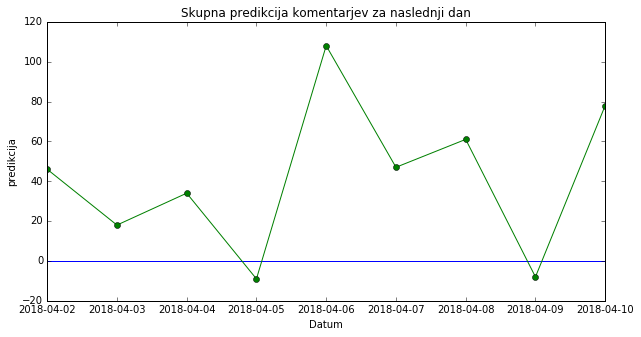

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10,5)

x_es = list(range(len(dd_full_predictions)))

plt.plot(x_es, [0 for x in x_es])

plt.plot(x_es, dd_full_predictions, linestyle='-',marker="o")

x_ticks = [dd_dates[i] for i in x_es]
plt.xticks(x_es, x_ticks)

plt.title("Skupna predikcija komentarjev za naslednji dan")


plt.xlabel("Datum")
plt.ylabel("predikcija")

In [11]:
dd_predictions = []

for full_prediction in dd_full_predictions:
    prediction = 0
    if full_prediction > 0:
        prediction = 1
    if full_prediction < 0:
        prediction = -1
    dd_predictions.append(prediction)
    
dd_predictions

[1, 1, 1, -1, 1, 1, 1, -1, 1]

In [12]:
# Evaluates the result

numOfCorrect = 0
numOfIncorrect = 0

print("Date      ", "Actual", "Predicted", "wasCorrect")
print("---------------------------------------")
for i in range(len(dd_predictions)):
    date = dd_dates[i] # there is no price prediction for first date
    prediction = dd_predictions[i]
    correct_prediction = bitstamp_price_correctPredictions[i]
    
    wasCorrect = prediction == correct_prediction
    if wasCorrect:
        numOfCorrect += 1
    else:
        numOfIncorrect += 1
    
    print(date, str(correct_prediction).rjust(6), str(prediction).rjust(9), str(wasCorrect).rjust(10))

print()
print(str(numOfCorrect) + "/" + str(numOfCorrect + numOfIncorrect))

Date       Actual Predicted wasCorrect
---------------------------------------
2018-04-02      1         1       True
2018-04-03     -1         1      False
2018-04-04     -1         1      False
2018-04-05     -1        -1       True
2018-04-06      1         1       True
2018-04-07     -1         1      False
2018-04-08     -1         1      False
2018-04-09      1        -1      False
2018-04-10      1         1       True

4/9
